In [1]:
from CPSsenv import CPSsenv
from Algorithms import CPSsalgorithms
import networkx as nx
from numpy.random import random, choice, seed
import matplotlib.pyplot as plt
import numpy as np
from time import time
from copy import copy, deepcopy

# Policy Evaluation

### Environment parameters

In [2]:
'''
ENVIRONMENT PARAMETERS
'''
network = 'SCADA'
T_max = 6
termination = 'one goal'
nw_params = {'Rewards': ['g5']}
rd_seed = 100
init_type = 'active list'
init_params = ['r1', 'k1', 's3', 's2']

### Environment and solver objects

In [3]:
'''
Creating environment object
'''
env = CPSsenv(network = network, T_max = T_max, termination = termination, nw_params = nw_params)


'''
Creating policy object
'''
solver = CPSsalgorithms(env, init_params = init_params)


### Q-Learning parameters

In [4]:
'''
Q-Learning parameters
'''
episodes = 15000
Episodes = range(episodes) 

alpha = 0.05                                     # How fast does the agent learn
gamma = 0.99                                    # How important are future actions

epsilon = 0.7                                   # Rate at which random actions will be 
start_e_decaying = 0                            # First episode at which decay epsilon
end_e_decaying = round(episodes * 0.7)          # Last episode at which decay epsilona
epsilon_decay_value = (epsilon - 0.03) / (end_e_decaying - start_e_decaying)

### Q-Learning Training

In [5]:
'''
# Q-Learning Training
'''
start = time()
q_table = {} 
episodes_rewards, successes, num_states = [], [], []
alphas = {attack:0 for attack in env.Attack_steps} 

for episode in Episodes:
    
    # Initializing environment
    
    state, available_actions = env.reset(init_type = init_type, init_params = init_params, rd_seed = rd_seed + episode) 
    done = False
    episode_reward = 0
    chosen_actions = []

    while not done:

        old_state = deepcopy(state)
        action = solver.Q_Learning_action(q_table, state, available_actions, epsilon = epsilon)

        chosen_actions.append(action)
        new_state, available_actions, reward, done, _ = env.step(action)
        episode_reward += reward

        q_table = solver.Q_Learning_update(q_table, old_state, action, reward, new_state, alpha = alpha, gamma = gamma)

        state = new_state

    if end_e_decaying >= episode >= start_e_decaying:       # Decay epsilon
        epsilon -= epsilon_decay_value

    episodes_rewards.append(episode_reward)
    successes.append(int(_['Success']))
    num_states.append(len(list(q_table.keys())))

    if _['Success']:
        for action in set(chosen_actions):
            alphas[action] += 1
                                               


# Training stats   
print('\n############################   Q-Learning Training   ############################\n')
print(f'Training time:                 {round(time() - start,2)} s')
print(f'Success prob on last 10% ep:   {round(sum(successes[int(0.9*episodes):])/(0.1*episodes),2)}')


############################   Q-Learning Training   ############################

Training time:                 12.12 s
Success prob on last 10% ep:   0.83


### Training performance

In [6]:
avg_episodes = 500
average_rewards = []
average_probs = []
for episode in Episodes:
    if episode <= avg_episodes/2:
        av_rw = sum(episodes_rewards[:avg_episodes])
        av_num = sum(successes[:avg_episodes]) 
        average_rewards.append(av_rw/(avg_episodes))
        average_probs.append(av_num/((avg_episodes)))
    elif episode <= episodes - avg_episodes/2:
        lower = int(episode-avg_episodes/2)
        upper = int(episode+avg_episodes/2)
        av_rw = sum(episodes_rewards[lower:upper])
        av_num = sum(successes[lower:upper])
        average_rewards.append(av_rw/(avg_episodes))
        average_probs.append(av_num/(avg_episodes))
    else:
        av_rw = sum(episodes_rewards[episodes - avg_episodes:])
        av_num = sum(successes[episodes - avg_episodes:])  
        average_rewards.append(av_rw/(avg_episodes))
        average_probs.append(av_num/((avg_episodes)))

#### Average Reward

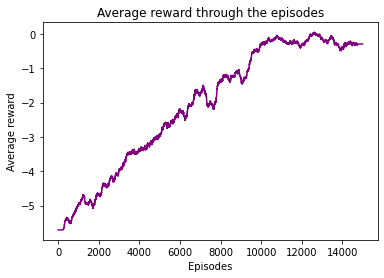

In [7]:
plt.plot(average_rewards, color = 'purple')
plt.title('Average reward through the episodes')
plt.xlabel('Episodes')
plt.ylabel('Average reward')
plt.show()

#### Average Success Rate

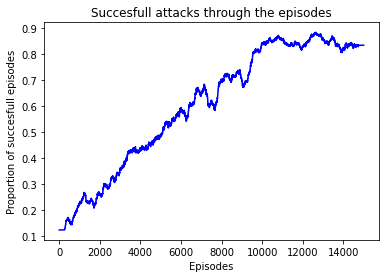

In [8]:
plt.plot(average_probs, color = 'blue')
plt.title('Succesfull attacks through the episodes')
plt.xlabel('Episodes')
plt.ylabel('Proportion of succesfull episodes')
plt.show()

#### Number of states

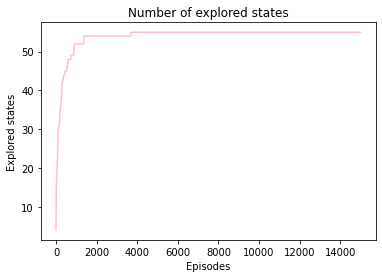

In [9]:
plt.plot(num_states, color = 'pink')
plt.title('Number of explored states')
plt.xlabel('Episodes')
plt.ylabel('Explored states')
plt.show()

#### Attack frequency on succesfull attacks

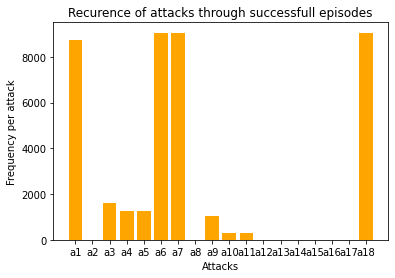

In [10]:
plt.bar(list(alphas.keys()), list(alphas.values()), color = 'orange')
plt.title('Recurence of attacks through successfull episodes')
plt.xlabel('Attacks')
plt.ylabel('Frequency per attack')
plt.show()

### Q-Learning testing

In [11]:
'''
Q-Learning testing
'''
episodes_rewards = [] 
sss = []
attacks = []
for episode in range(50):
    state, available_actions = env.reset(init_type = init_type, init_params = init_params, rd_seed = rd_seed * 2)
    done = False
    episode_reward = 0
    summary = []

    while not done:

        old_state = deepcopy(state)
        action = solver.Q_Learning_action(q_table, state, available_actions, epsilon = 0)
        attacks.append(action)

        new_state, available_actions, reward, done, _ = env.step(action)
        episode_reward += reward

        summary.append((old_state[0], old_state[3], action))

        state = new_state
        
    sss.append(int(_['Success']))
    episodes_rewards.append(episode_reward)

print(f'Success rate: {round(sum(sss)/50,2)}')
print(f'Avg reward:   {round(sum(episodes_rewards)/50,2)}')

Success rate: 0.78
Avg reward:   -0.51


### Value Iteration

In [12]:
'''
Value iteration
'''
gamma = 0.99
theta = 1e-12
state, available_actions = env.reset(init_type = init_type, init_params = init_params)
start = time()
States = solver.generate_states(env, loops = 50000, load = False)
V_hat, policy = solver.Value_Iteration(env, States, gamma, theta)

print('\n############################   Value Iteration Computing   ############################\n')
print(f'Computing time:                 {round(time() - start,2)} s')

'''
Value Iteration Testing
'''
episodes_rewards = [] 
sss = []

for episode in range(1):
    state, available_actions = env.reset(init_type = init_type, init_params = init_params, rd_seed = rd_seed * 750)
    done = False
    episode_reward = 0
    summary = []

    while not done:

        old_state = deepcopy(state)
        old_sttate = solver.translate_state(old_state)
        action = policy[tuple(old_sttate)]
        print(action)

        new_state, available_actions, reward, done, _ = env.step(action)
        episode_reward += reward

        summary.append((old_state[0], old_state[3], action))

        state = new_state

    sss.append(int(_['Success']))
    episodes_rewards.append(episode_reward)


# Testing stats
print('\n############################   Value Iteration Test   ############################\n')
print(f'Success rate: {round(sum(sss)/50,2)}')
print(f'Avg reward:   {round(sum(episodes_rewards)/50,2)}')



############################   Value Iteration Computing   ############################

Computing time:                 30.16 s
a1
a6
a6
a6
a7
a4
a4
a4

############################   Value Iteration Test   ############################

Success rate: 0.0
Avg reward:   -0.14


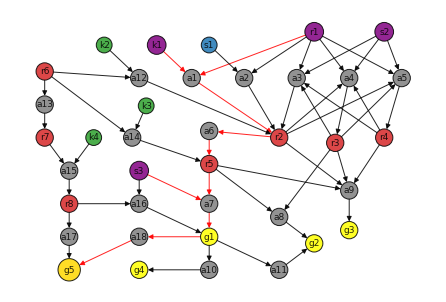

In [13]:
info = env.reset(init_type = init_type, init_params = init_params)
attacks = set(attacks)
env.render(attacks = attacks)